### CaixaBank Tech Hackathon

In [1]:
#Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
import re

#SK Learn
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  PowerTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn.cluster import DBSCAN

#NLP
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
sns.set(style='darkgrid')
nltk.download('omw-1.4')




sns.set(style='darkgrid')
pd.set_option('display.max_columns',None)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/albert/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/albert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/albert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/albert/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
5,1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
6,1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
7,1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1
8,1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1
9,1994-01-14,3680.800049,3737.399902,3662.899902,3736.399902,3736.395996,0.0,1


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6421 non-null   float64
 2   High       6421 non-null   float64
 3   Low        6421 non-null   float64
 4   Close      6421 non-null   float64
 5   Adj Close  6421 non-null   float64
 6   Volume     6421 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


In [5]:
train_data.describe()

,Open,High,Low,Close,Adj Close,Volume,Target
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,6.421000e+03,6554.000000
mean,8936.540448,9005.235576,8858.340567,8934.978558,8934.970624,8.218074e+07,0.516936
std,2732.102441,2749.009324,2712.511028,2731.032625,2731.030170,1.231845e+08,0.499751
min,2865.100098,2877.300049,2833.600098,2865.100098,2865.097168,0.000000e+00,0.000000
25%,7732.399902,7817.200195,7641.500000,7727.799805,7727.791992,0.000000e+00,0.000000
50%,9329.700195,9404.599609,9243.000000,9331.000000,9331.000000,1.966000e+05,1.000000
75%,10525.500000,10590.299805,10441.200195,10523.400391,10523.400391,1.773980e+08,1.000000
max,15999.200195,16040.400391,15868.599609,15945.700195,15945.683594,7.894902e+08,1.000000


In [6]:
train_data.isnull().sum()

Date           0
Open         133
High         133
Low          133
Close        133
Adj Close    133
Volume       133
Target         0
dtype: int64

In [7]:
train_data = train_data.dropna()

In [8]:
# Transforms column into date type
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Date'] = train_data['Date'].apply(lambda x: x.date())

In [9]:
# Creates variable indicating day of the week
train_data['Weekday'] = train_data['Date'].apply(lambda x: x.weekday())

In [10]:
# Selects those rows that have a positive value for the volume column
train_data = train_data.loc[train_data['Volume'] > 0.0]

In [11]:
# Creates new variable that calculates the variation of the stock market index
train_data['Variation'] = ((train_data['Close']-train_data['Open'])/train_data['Open'])*100

In [12]:
# Creates new variable indicating the variation from the previous observation
train_data['Previous variation'] = train_data['Variation'].shift(+1)

In [13]:
# Creates new variable showing the average variation of the last 3 days
train_data['Previous 3 days variation'] = (
    train_data['Variation'].shift(+1) + 
    train_data['Variation'].shift(+2) +
    train_data['Variation'].shift(+3)) /3

In [14]:
# Creates a new binary variable indicating whether the last 4 consecutive 
# days there has been a positive variation or not
train_data['Previous 4 days cons pos var']=np.where((train_data['Variation'].shift(+1)<0)&
                                            (train_data['Variation'].shift(+2)<0)&
                                            (train_data['Variation'].shift(+3)<0)&
                                            (train_data['Variation'].shift(+4)<0),1,0)

In [15]:
# Creates a new binary variable indicating whether the last 3 consecutive 
# days there has been a positive variation or not
train_data['Previous 3 days cons pos var']=np.where((train_data['Variation'].shift(+1)>0)&
                                            (train_data['Variation'].shift(+2)>0)&
                                            (train_data['Variation'].shift(+3)>0),1,0)

In [16]:
# Creates a new binary variable indicating whether the last 2 consecutive 
# days there has been a negative variation or not
train_data['Previous 3 days cons neg var']=np.where((train_data['Variation'].shift(+1)<0)&
                                            (train_data['Variation'].shift(+2)<0)&
                                            (train_data['Variation'].shift(+3)<0),1,0)

In [17]:
# Creates a new variable showing the difference between the opening price
# and the highest price
#train_data['High Difference'] = train_data['High']-train_data['Open']

In [18]:
# Creates a new variable showing the difference between the highest and the lowest price
train_data['Amplitude'] = ((train_data['High']-train_data['Low'])/train_data['Low'])*100

In [19]:
# Creates a new variable showing the difference between the opening price
# and the lowest price
#train_data['Low Difference'] = train_data['Open']-train_data['Low']

In [20]:
#train_data['Low above the mean'] = np.where((train_data['Low Difference'].shift(+1)>np.mean(train_data['Low Difference']))&
#                                           (train_data['Low Difference'].shift(+2)>np.mean(train_data['Low Difference'])),1,0)

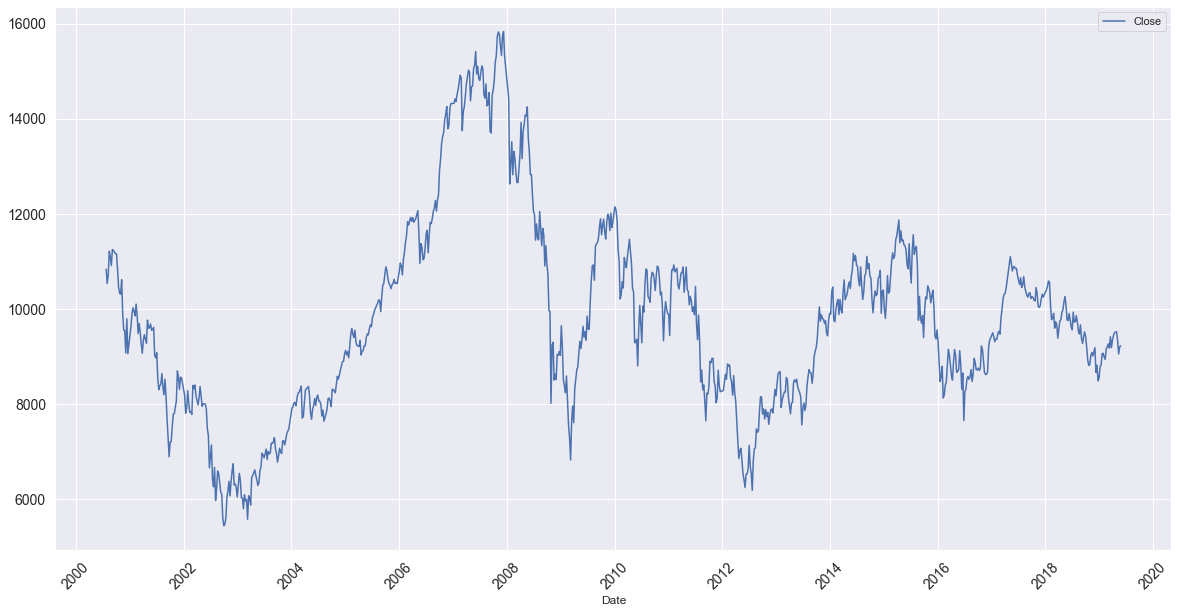

In [21]:
# Take only Mondays and create a new dataframe with the date and the 
# closing price
sunday_data = train_data.loc[train_data['Weekday'] == 0]
sd_df = pd.DataFrame({'Close': sunday_data['Close'],
                      'Date':sunday_data['Date']})

# Plots the result
sd_df = sd_df.set_index('Date')
sd_df.plot(rot=45, figsize=(20, 10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

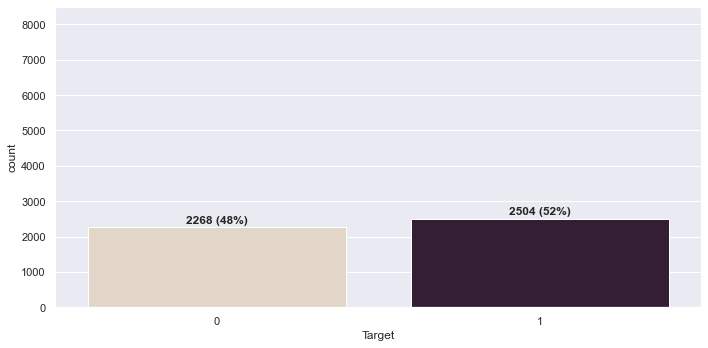

In [22]:
# Countplot of categorical target variable
fig, axes = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Target',palette='ch:.25',data=train_data)
ax.set_ylim(0,8500)

abs_values = train_data['Target'].value_counts(sort=False).values
rel_values = train_data['Target'].value_counts(sort=False, normalize=True).values * 100
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=labels,weight='bold',padding=2)
fig.tight_layout(h_pad=2)

In [23]:
# Creates correlation matrix masking repeated values
matrix_corr = train_data.corr()

mask = np.triu(np.ones_like(matrix_corr))[1:, :-1]
matrix = matrix_corr.iloc[1:, :-1].copy()

cmap = sns.color_palette("ch:.25", as_cmap=True)

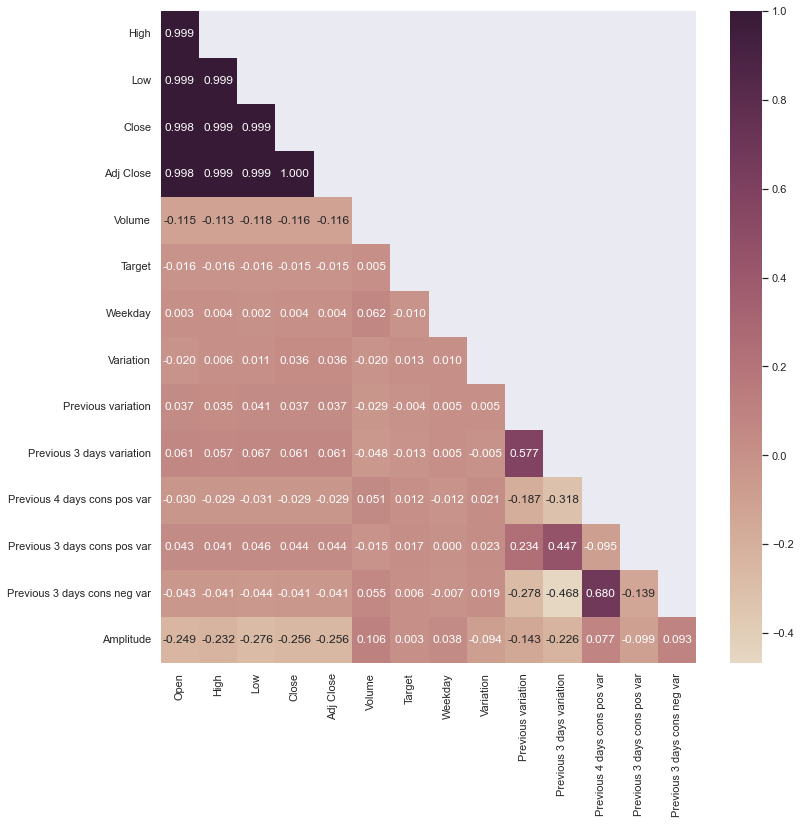

In [24]:
# Plots the matrix
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, mask=mask, annot=True, fmt=".3f", cmap=cmap)
plt.show()

In [25]:
# Rearranges the columns to separate them more easily
train_data2 = train_data[[col for col in train_data if col not in ['Date','Weekday','Adj Close','Target']]+ ['Date','Weekday','Adj Close','Target']]

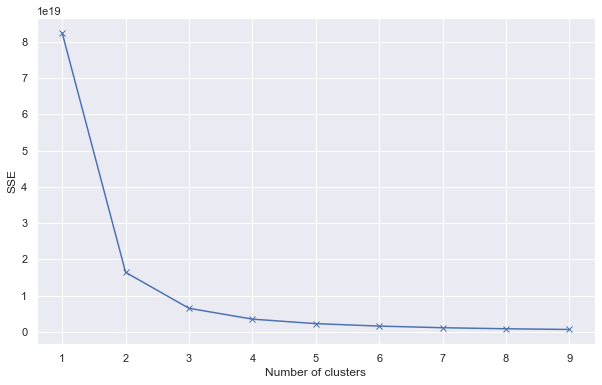

In [26]:
# Plots sum of squared errors for different number of clusters
sse = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(train_data2.iloc[3:,:-4])
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(K,sse,'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [27]:
train_data2.iloc[3:,:-4]

,Open,High,Low,Close,Volume,Variation,Previous variation,Previous 3 days variation,Previous 4 days cons pos var,Previous 3 days cons pos var,Previous 3 days cons neg var,Amplitude
1713,10743.799805,10856.599609,10713.400391,10726.000000,6989400.0,-0.165675,0.197715,-0.441219,0,0,0,1.336636
1714,10726.000000,10735.000000,10526.799805,10560.000000,6670000.0,-1.547641,-0.165675,-0.349074,0,0,0,1.977811
1715,10560.000000,10584.700195,10375.000000,10531.599609,7334200.0,-0.268943,-1.547641,-0.505200,0,0,0,2.021207
1716,10531.599609,10591.299805,10481.099609,10549.000000,6354300.0,0.165221,-0.268943,-0.660753,0,0,1,1.051418
1717,10549.000000,10656.099609,10522.799805,10644.500000,7650100.0,0.905299,0.165221,-0.550455,0,0,0,1.266771
...,...,...,...,...,...,...,...,...,...,...,...,...
6549,9150.299805,9211.099609,9141.400391,9174.599609,121673100.0,0.265563,-0.618276,-0.169974,0,0,0,0.762457
6550,9225.900391,9294.599609,9204.700195,9216.400391,60178000.0,-0.102971,0.265563,-0.117931,0,0,0,0.976669
6551,9220.400391,9224.900391,9132.900391,9191.799805,218900800.0,-0.310188,-0.102971,-0.151895,0,0,0,1.007347
6552,9113.200195,9116.700195,9035.099609,9080.500000,148987100.0,-0.358822,-0.310188,-0.049199,0,0,0,0.903151


In [28]:
# Computes kmeans algorithm on the dataset
kmeans_model = KMeans(n_clusters=3)
km_clusters = kmeans_model.fit_predict(train_data2.iloc[3:,:-4])

In [29]:
# Deletes the first 3 rows as they have nan values for some columns
train_data2 = train_data2.iloc[3:,:]

In [30]:
# Inserts kmeans cluster labels as new column
train_data2.insert(1,'Kmeans Groups', km_clusters)

In [31]:
# Rearranges the columns to separate them more easily
train_data2 = train_data2[[col for col in train_data2 if col not in ['Kmeans Groups','Date','Weekday','Adj Close','Target']]+ ['Kmeans Groups','Target']]

In [32]:
# Creates a copy for the xgb algorithm since it does not accept 
# categorical variables yet
train_data_xgb = train_data2.copy()

In [33]:
# Converts the desired variables to categorical
train_data2['Kmeans Groups'] = train_data2['Kmeans Groups'].astype('category')
train_data2['Previous 4 days cons pos var'] = train_data2['Previous 4 days cons pos var'].astype('category')
train_data2['Previous 3 days cons pos var'] = train_data2['Previous 3 days cons pos var'].astype('category')
train_data2['Previous 3 days cons neg var'] = train_data2['Previous 3 days cons neg var'].astype('category')

In [34]:
# Selects features
X = train_data2.iloc[:,:-1]
X_xgb = train_data_xgb.iloc[:,:-1]

In [35]:
# Selects dependent variable
y = train_data2.iloc[:,-1:]
y = np.array(y).ravel()

y_xgb = train_data2.iloc[:,-1:]
y_xgb = np.array(y).ravel()

In [36]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size = 0.25, random_state=42)

In [37]:
# Dictionary to store nested cross-validation scores
model_scores = {}

# Dictionary to store model and param grid mapping
model_param_grid = {}

In [38]:
def nested_crossval(model,model_label,X,y,scoring, 
                    model_param_grid=model_param_grid, 
                    model_scores = model_scores):
    '''
    Inputs:
    model        : Regression Model
    model_label        : Regression model label
    model_param_grid : List of parameter grids
    X                : explanatory variables 
    y                : response variable array
    model_scores     : Dictionary to store nested cross-validation scores
    
    Outputs:
    model_scores     : Updated dictionary of nested cross-validation scores
    '''
    
    # Creates an instance of GridSearch cross-validation estimator 
    gs = (GridSearchCV(estimator=model, 
                            param_grid=model_param_grid[model_label], 
                            cv=2,
                            scoring = scoring,
                            n_jobs = 1))
    
    # Evaluates the GS instance by cross-valdiation
    scores = cross_val_score(estimator=gs,
                            X=X,
                            y=y,
                            cv=5,
                            scoring= scoring)
        
    # Computes F1 macro for   
    print("F1 Macro: %0.2f (+/- %0.2f) [%s]"
              % (scores.mean(), scores.std(), model_label))
        
    # Adds result to 'model_scores' dictionary
    model_scores[model_label] = scores
        
    
    return model_scores

In [39]:
#KNN classifier
knnclassifier = KNeighborsClassifier()
#Grid param
grid_param_knn = {
    'n_neighbors': [2,3,5,7],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','minkowski','manhattan'],
    'n_jobs': [-1]
}

model_param_grid['KNN Classifier'] = grid_param_knn

###############################################


#Random Forest Classifier
rf = RandomForestClassifier(random_state=1)

grid_param_rf = {
    'n_jobs': [-1],
    'n_estimators': [100,150,200,250],
    'max_depth': [3,6,9],
    'min_samples_leaf': [5,10,20,30]
}
    
model_param_grid['RF Classifier'] = grid_param_rf

###############################################

# XGBoost Classifier
xgbclassifier = XGBClassifier(random_state=1, use_label_encoder=False,
                             enable_categorical=True)
#Grid param for building with 4 floors
param_grid_xgb = {
    
    'eval_metric': ['merror', 'error'],
    'max_depth': [3,6,9],
    'n_estimators': [100,150,200,250],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_jobs': [-1]
}

model_param_grid['XGB Classifier'] = param_grid_xgb

In [40]:
#model_scores = nested_crossval(xgbclassifier, 'XGB Classifier', X_train_xgb, y_train_xgb, 'f1_macro')

In [41]:
model_scores = nested_crossval(knnclassifier, 'KNN Classifier', X_train, y_train, 'f1_macro')

F1 Macro: 0.53 (+/- 0.02) [KNN Classifier]


In [42]:
model_scores = nested_crossval(rf, 'RF Classifier', X_train, y_train, 'f1_macro')

F1 Macro: 0.54 (+/- 0.02) [RF Classifier]


In [43]:
def model_fitting_testing(model,model_label ,X_train,y_train,X_test,y_test, scoring,model_param_grid = model_param_grid):
    
    '''
    Inputs:
    model            : Regression or Classification model
    model_label      : Regression or Classification model label
    model_param_grid : List of parameter grids
    X_train          : Explanatory train variables 
    y_train          : Response train variable
    X_test           : Explanatory train variables 
    y_test           : Response train variable
    scoring          : Metric to evaluate the perfomance of the cross-validated model
    
    Outputs:
    final_models     : Updated dictionary of nested cross-validation scores
    preds            : Resulting predictions
    '''
    
    # Creates an instance of GridSearch cross-validation estimator
    gs = (GridSearchCV(estimator= model, 
        param_grid=model_param_grid[model_label], 
        cv=10,
        scoring = scoring,
        n_jobs = 1))
            
            
    
    # Fits the GS instance
    gs_fit = gs.fit(X_train, y_train)
    # Fits the best estimator obtained as  a final model
    gs_tuned = gs_fit.best_estimator_.fit(X_train, y_train)
    
    
    # Predicts probabilities and keep them for the positive outcome only
    y_scores = gs_tuned.predict_proba(X_test)[:,1]
    
    # Calculates roc curves
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Gets the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_t = thresholds[ix]
    print('Best ROC Curve Threshold=%f' % (best_t))
    
    # Predictions,classification report,confusion matrix and other metrics
    preds = [1 if y >= best_t else 0 for y in y_scores]
    
    cl_report = classification_report(y_test, preds)
    cm = pd.DataFrame(confusion_matrix(y_test, preds))
    f1 = f1_score(y_test,preds, average='macro')
    accuracy = accuracy_score(y_test, preds)
    bal_accuracy = balanced_accuracy_score(y_test, preds)
    kappa = cohen_kappa_score(y_test, preds)
    
    # Plots the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= model_label)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
     
    #Prints preds,classification report and confusion matrix
    print(cl_report)
    print(cm)
    print("\n")
    print("F1_score :",f1)
    print("Accuracy :",accuracy)
    print("Balanced accuracy :",bal_accuracy)
    print("Cohen's kappa :",kappa)

    
    # Adds the tuned model and results to 'final_models' dictionary
    final_models[model_label] = [gs_tuned, f1_score, bal_accuracy, kappa]
    
    
    

    
    return final_models,preds

In [44]:
# Dictionary to store final results
final_models = {}

Best ROC Curve Threshold=0.518617


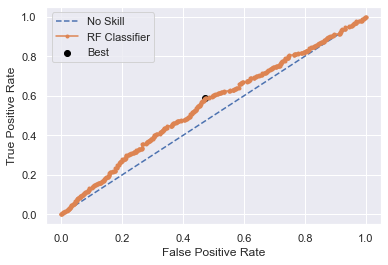

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       573
           1       0.57      0.59      0.58       620

    accuracy                           0.56      1193
   macro avg       0.56      0.56      0.56      1193
weighted avg       0.56      0.56      0.56      1193

     0    1
0  303  270
1  256  364


F1_score : 0.5579389768993637
Accuracy : 0.559094719195306
Balanced accuracy : 0.5579462928559364
Cohen's kappa : 0.1160000112697962


In [45]:
final_models,preds = model_fitting_testing(rf,'RF Classifier', X_train, y_train,
                                     X_test, y_test, 'f1_macro')

Best ROC Curve Threshold=0.600000


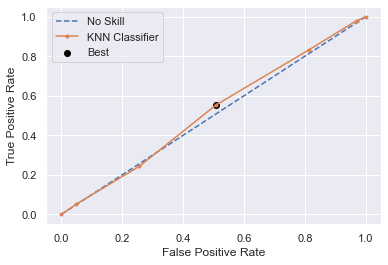

              precision    recall  f1-score   support

           0       0.50      0.49      0.50       573
           1       0.54      0.55      0.55       620

    accuracy                           0.52      1193
   macro avg       0.52      0.52      0.52      1193
weighted avg       0.52      0.52      0.52      1193

     0    1
0  282  291
1  277  343


F1_score : 0.5226413286669935
Accuracy : 0.5238893545683152
Balanced accuracy : 0.5226862016551258
Cohen's kappa : 0.045414460838867354


In [46]:
final_models,preds2 = model_fitting_testing(knnclassifier,'KNN Classifier', X_train, y_train,
                                     X_test, y_test, 'f1_macro')

In [47]:
# Inserts y_test into X_test
X_test.insert(1,'target',y_test)

In [48]:
# Inserts preds
X_test.insert(1,'preds',preds)

In [49]:
# Rearranges columns to have preds and y_test at the end 
X_test=X_test[[col for col in X_test if col not in ['target', 'preds']]+ ['target', 'preds']]

In [50]:
ola = X_test.loc[(X_test['target']==0)&(X_test['preds']==1)]

In [51]:
ix_list = list(ola.index)

In [52]:
error_frame = train_data.loc[ix_list]
error_frame = error_frame[['Close', 'Date']].set_index('Date')

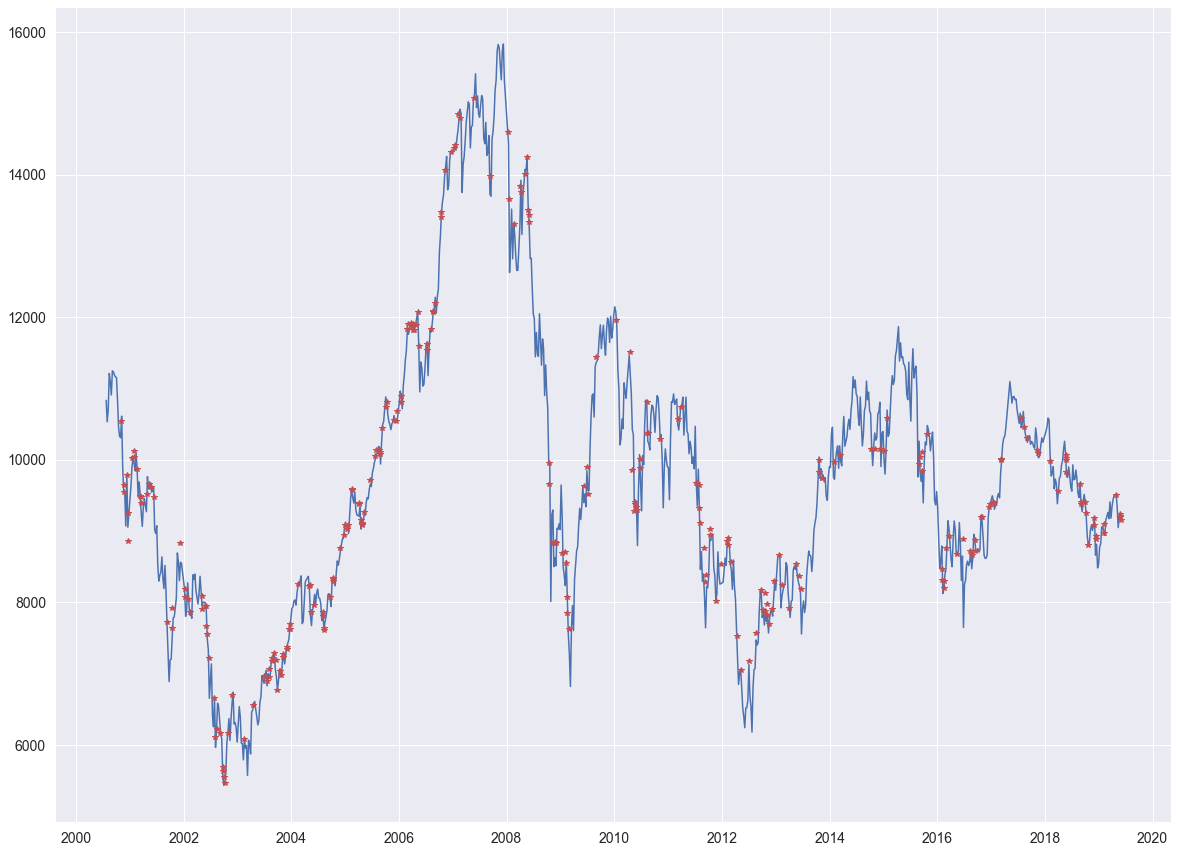

In [53]:
fig, ax1 = plt.subplots(figsize=(20, 15))
ax1.plot(sd_df)
ax1.plot(error_frame, 'r*')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [54]:
test_data = pd.read_csv('test_x.csv')

In [55]:
test_data

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [56]:
# Creates new variable that calculates the variation of the stock market index
test_data['Variation'] = ((test_data['Close']-test_data['Open'])/test_data['Open'])*100

In [57]:
# Creates new variable indicating the variation from the previous observation
test_data['Previous variation'] = test_data['Variation'].shift(+1)

In [58]:
# Creates new variable showing the average variation of the last 3 days
test_data['Previous 3 days variation'] = (
    test_data['Variation'].shift(+1) + 
    test_data['Variation'].shift(+2) +
    test_data['Variation'].shift(+3)) /3

In [59]:
# Creates a new binary variable indicating whether the last 4 consecutive 
# days there has been a positive variation or not
test_data['Previous 4 days cons pos var']=np.where((test_data['Variation'].shift(+1)<0)&
                                            (test_data['Variation'].shift(+2)<0)&
                                            (test_data['Variation'].shift(+3)<0)&
                                            (test_data['Variation'].shift(+4)<0),1,0)

In [60]:
# Creates a new binary variable indicating whether the last 3 consecutive 
# days there has been a positive variation or not
test_data['Previous 3 days cons pos var']=np.where((test_data['Variation'].shift(+1)>0)&
                                            (test_data['Variation'].shift(+2)>0)&
                                            (test_data['Variation'].shift(+3)>0),1,0)

In [61]:
# Creates a new binary variable indicating whether the last 2 consecutive 
# days there has been a negative variation or not
test_data['Previous 3 days cons neg var']=np.where((test_data['Variation'].shift(+1)<0)&
                                            (test_data['Variation'].shift(+2)<0)&
                                            (test_data['Variation'].shift(+3)<0),1,0)

In [62]:
# Creates a new variable showing the difference between the highest and the lowest price
test_data['Amplitude'] = ((test_data['High']-test_data['Low'])/test_data['Low'])*100

In [63]:
# Rearranges the columns to separate them more easily
test_data2 = test_data[[col for col in test_data if col not in ['Date','Adj Close']]+ ['Date','Adj Close']]

In [64]:
km_clusters_test = kmeans_model.predict(test_data2.iloc[3:,1:-2])

In [65]:
# Deletes the first 3 rows as they have nan values for some columns.
test_data2 = test_data2.iloc[3:,:]

In [66]:
# Inserts kmeans cluster labels as new column
test_data2.insert(1,'Kmeans Groups', km_clusters_test)

In [67]:
# Rearranges the columns to separate them more easily
test_data2 = test_data2[[col for col in test_data2 if col not in ['test_index','Kmeans Groups','Date','Adj Close']]+ ['Kmeans Groups']]

In [68]:
test_preds = final_models['RF Classifier'][0].predict(test_data2)

In [69]:
test_df = pd.DataFrame({'test_index':test_data.iloc[3:,:]['test_index'], 'Target': test_preds})

In [70]:
test_df

,test_index,Target
3,6560,1
4,6561,1
5,6562,1
6,6563,1
7,6564,1
...,...,...
721,7278,1
722,7279,1
723,7280,1
724,7281,1


In [71]:
test_df.to_csv('predictions.csv',index=False)

In [72]:
test_json = pd.read_csv('predictions.csv')

In [73]:
test_json

,test_index,Target
0,6560,1
1,6561,1
2,6562,1
3,6563,1
4,6564,1
...,...,...
718,7278,1
719,7279,1
720,7280,1
721,7281,1


In [74]:
test_json.to_json('predictions.json')